In [5]:
pip install tensorflow


  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30702 sha256=0232d584415299ed8fed5d6d7c36cade50f92290609fe58e502c1d19a5f58d39
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\f1\60\77\22b9b5887bd47801796a856f47650d9789c74dc3161a26d608
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4829 sha256=c113bc76721134a27f5411a0a7dabb8794440444045a260720d46b9c4de9483a
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\a0\16\9c\5473df82468f958445479c59e784896fa24f4a5fc024b0f501
Successfully built clang termcolor
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.1
    Uninstalling numpy-1.20.1:
      Successfully uninstalled numpy-1.20.1
  Attempting uninstall: h5py
    Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10.0


In [9]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
import warnings
import numpy as np
import cv2
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, EarlyStopping
warnings.simplefilter(action='ignore', category=FutureWarning)
import sklearn.metrics as metrics


background = None
accumulated_weight = 0.5

toproi = 100
bottomroi = 300
rightroi = 150
leftroi = 350


In [2]:
def puttext(image, text, org, font, fontScale, color, thickness):
    cv2.putText(image, text, org, font, fontScale, color, thickness)
    
def makingrectangle(image, start_point, end_point, color, thickness):
    cv2.rectangle(image, start_point, end_point, color, thickness)
    
def show(window_name, image):
    cv2.imshow(window_name, image)

def segment_hand(frameinstance, threshold=25):
    global background
    diff = cv2.absdiff(background.astype("uint8"), frameinstance)
    _ , threshold = cv2.threshold(diff, threshold,255,cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(threshold.copy(),
    cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return None
    else:
        hand_segment_max_cont = max(contours, key=cv2.contourArea)
        return (threshold, hand_segment_max_cont)
    
def detectinghandfl300(hand, copiedframeinstance, rightroi,toproi, frameinstancesnum, curelement):
    threshold, hand_segment = hand
    cv2.drawContours(copiedframeinstance, [hand_segment + (rightroi,toproi)], -1, (255, 0, 0),1)
    puttext(copiedframeinstance, str(frameinstancesnum)+"For" + str(curelement),(70, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
    show("threshold Hand Image", threshold)
    

def detectinghandgl300(hand, copiedframeinstance, rightroi,toproi, frameinstancesnum, curelement, takenimgs):    
    threshold, hand_segment = hand
    cv2.drawContours(copiedframeinstance, [hand_segment + (rightroi,toproi)], -1, (255, 0, 0),1)
    puttext(copiedframeinstance, str(frameinstancesnum), (70, 45),cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
    puttext(copiedframeinstance, str(takenimgs) + 'images' +"For"+ str(curelement), (200, 400), cv2.FONT_HERSHEY_SIMPLEX, 1,(0,0,255), 2)
    return threshold
    
def ls300(variable):
    if(variable<=200):
        return True
    else:
        return False
    
def checknone(variable):
    if(variable is None):
        return False
    else:
        return True

def cal_accum_avg(frameinstance, accumulated_weight):
    global background
    if background is None:
        background = frameinstance.copy().astype("float")
        return None
    cv2.accumulateWeighted(frameinstance, background, accumulated_weight)

In [24]:
camera = cv2.VideoCapture(0)
frameinstancesnum = 0
curelement = 7
takenimgs = 0

while True:
    ret, frameinstance = camera.read()
    frameinstance = cv2.flip(frameinstance, 1)
    copiedframeinstance = frameinstance.copy()
    roi = frameinstance[toproi:bottomroi, rightroi:leftroi]
    frameinstancegray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    frameinstancegray = cv2.GaussianBlur(frameinstancegray, (9, 9), 0)
    
    
    if frameinstancesnum < 60:
        cal_accum_avg(frameinstancegray, accumulated_weight)
        if frameinstancesnum <= 59:
            text = "Getting the background..."
            puttext(copiedframeinstance, text,(80, 400), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,255), 2)
            
            
    elif ls300(frameinstancesnum): 
        hand = segment_hand(frameinstancegray)
        text = "Adjust Hand Gesture for" + str(curelement)
        puttext(copiedframeinstance, text, (200, 400), cv2.FONT_HERSHEY_SIMPLEX, 1,(0,0,255),2)
        if checknone(hand):
            detectinghandfl300(hand, copiedframeinstance, rightroi,toproi, frameinstancesnum, curelement)    
            
            
        
    else: 
        
        hand = segment_hand(frameinstancegray)
        if checknone(hand):
            threshold = detectinghandgl300(hand, copiedframeinstance, rightroi,toproi, frameinstancesnum, curelement, takenimgs)
            show("Threshold Hand Image", threshold)
            if ls300(takenimgs):
                text = r"F:\\capstonetrying\\gesture\\test\\"+str(curelement)+"\\" + str(takenimgs) + '.jpg'
                cv2.imwrite(text, threshold)   
            else:
                break
            takenimgs +=1 
        else:
            text = 'No hand detected...'
            puttext(copiedframeinstance, text, (200, 400),cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

            
    makingrectangle(copiedframeinstance, (leftroi, toproi), (rightroi,bottomroi), (255,128,0), 3)
    puttext(copiedframeinstance, "Hand sign recognition_ _ _", (10, 20), cv2.FONT_ITALIC, 0.5, (51,255,51), 1)
    frameinstancesnum += 1
    show("Sign Detection", copiedframeinstance)
    k = cv2.waitKey(1) & 0xFF
    if k == 27:
        break
        
        
cv2.destroyAllWindows()
camera.release()

In [7]:
train_path = r"F:\\capstonetrying\\gesture\\train"
test_path = r"F:\\capstonetrying\\gesture\\test"

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_path, target_size=(64,64), class_mode='categorical', batch_size=10,shuffle=True)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_path, target_size=(64,64), class_mode='categorical', batch_size=10, shuffle=True)

Found 7100 images belonging to 10 classes.
Found 400 images belonging to 10 classes.


In [42]:
print(len(train_batches))

710


In [26]:
import matplotlib.pyplot as plt
imgs, labels = next(train_batches)
print(labels)
print(len(imgs[2][0]))

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
64


In [9]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64,64,3)))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'valid'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Flatten())

model.add(Dense(64,activation ="relu"))
model.add(Dense(128,activation ="relu"))
model.add(Dense(128,activation ="relu"))
model.add(Dense(10,activation ="softmax"))

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 31, 31, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)             

In [11]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')


model.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0005)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

In [12]:
history = model.fit(train_batches, epochs=10,  validation_data = test_batches)
#callbacks=[reduce_lr, early_stop],

Epoch 1/10
710/710 [==============================] - 148s 207ms/step - loss: 0.2376 - accuracy: 0.9787 - val_loss: 2.2783 - val_accuracy: 0.5400
Epoch 2/10
710/710 [==============================] - 112s 158ms/step - loss: 9.7110e-04 - accuracy: 1.0000 - val_loss: 2.4409 - val_accuracy: 0.5450
Epoch 3/10
710/710 [==============================] - 114s 161ms/step - loss: 5.1345e-04 - accuracy: 1.0000 - val_loss: 2.5047 - val_accuracy: 0.5475
Epoch 4/10
710/710 [==============================] - 119s 167ms/step - loss: 3.3931e-04 - accuracy: 1.0000 - val_loss: 2.5593 - val_accuracy: 0.5500
Epoch 5/10
710/710 [==============================] - 110s 155ms/step - loss: 2.5287e-04 - accuracy: 1.0000 - val_loss: 2.5886 - val_accuracy: 0.5500
Epoch 6/10
710/710 [==============================] - 118s 167ms/step - loss: 1.9861e-04 - accuracy: 1.0000 - val_loss: 2.6404 - val_accuracy: 0.5500
Epoch 7/10
710/710 [==============================] - 120s 169ms/step - loss: 1.6406e-04 - accuracy: 1.0

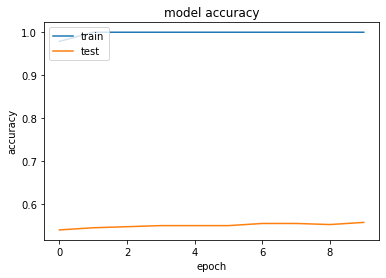

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

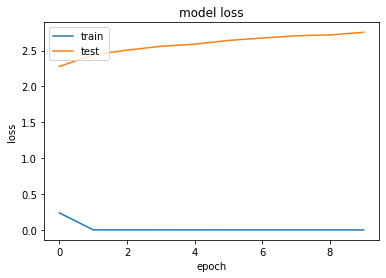

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
preds = np.round(model.predict(test_batches),0)
print("rounded test labels", preds)

rounded test labels [[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [44]:
scores = model.evaluate(imgs, labels, verbose=0)
print(f'{model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

model_json = model.to_json()
with open("F:\\capstonetrying\\New folder (2)\\model\\model_json.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("F:\\capstonetrying\\New folder (2)\\model\\model_weights.h5")
model.save("F:\\capstonetrying\\model.h5")

loss of 1.5265294313430786; accuracy of 69.9999988079071%


In [6]:
import numpy as np
import cv2
import keras
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [4]:
model = keras.models.load_model(r"F:\\capstonetrying\\model.h5")

background = None
accumulated_weight = 0.5

ROI_top = 100
ROI_bottom = 300
ROI_right = 150
ROI_left = 350

In [5]:
def cal_accum_avg(frame, accumulated_weight):
    global background
    if background is None:
        background = frame.copy().astype("float")
        return None
    cv2.accumulateWeighted(frame, background, accumulated_weight)

In [6]:
def segment_hand(frame, threshold=25):
    global background
    diff = cv2.absdiff(background.astype("uint8"), frame)
    _ , thresholded = cv2.threshold(diff, threshold, 255,cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(thresholded.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return None
    else:
        hand_segment_max_cont = max(contours, key=cv2.contourArea)
        return (thresholded, hand_segment_max_cont)

In [12]:
cam = cv2.VideoCapture(0)
num_frames =0
word_dict = {0:'Zero',1:'One',2:'Two',3:'Three',4:'Four',5:'Five',6:'Six',7:'Seven',8:'Eight',9:'Nine'}

while True:
    ret, frame = cam.read()
    frame = cv2.flip(frame, 1)
    frame_copy = frame.copy()
    roi = frame[ROI_top:ROI_bottom, ROI_right:ROI_left]
    gray_frame = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    gray_frame = cv2.GaussianBlur(gray_frame, (9, 9), 0)
    if num_frames < 70:   
        cal_accum_avg(gray_frame, accumulated_weight)
        cv2.putText(frame_copy, "Getting the Background...", (80, 400), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,255), 2)
    else: 
        hand = segment_hand(gray_frame)
        if hand is not None:  
            thresholded, hand_segment = hand
            cv2.drawContours(frame_copy, [hand_segment + (ROI_right,ROI_top)], -1, (255, 0, 0),1)
            cv2.imshow("Thesholded Hand Image", thresholded)
            thresholded = cv2.resize(thresholded, (64, 64))
            thresholded = cv2.cvtColor(thresholded,cv2.COLOR_GRAY2RGB)
            thresholded = np.reshape(thresholded,(1,thresholded.shape[0],thresholded.shape[1],3))
            pred = model.predict(thresholded)
            cv2.putText(frame_copy, word_dict[np.argmax(pred)], (170, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
    cv2.rectangle(frame_copy, (ROI_left, ROI_top), (ROI_right,ROI_bottom), (255,128,0), 3)
    num_frames += 1
    cv2.putText(frame_copy, "---SignHGD Project---",
    (10, 20), cv2.FONT_ITALIC, 0.5, (51,255,51), 1)
    cv2.imshow("Sign Detection", frame_copy)
    k = cv2.waitKey(1) & 0xFF

    if k == 27:
        break

cam.release()
cv2.destroyAllWindows()